In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, top_k_accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, NearMiss

In [11]:
def column_adjustor(dataset_column):
    codes, uniques = pd.factorize(dataset_column)
    return pd.Series(codes, index=dataset_column.index), uniques.tolist()

In [12]:
labels_with_few_samples = ['web_attack', 'exploit_source']

In [13]:
all_accuracy_scores = {}
all_confusion_matrices = {}

## Oversampling

/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be remov

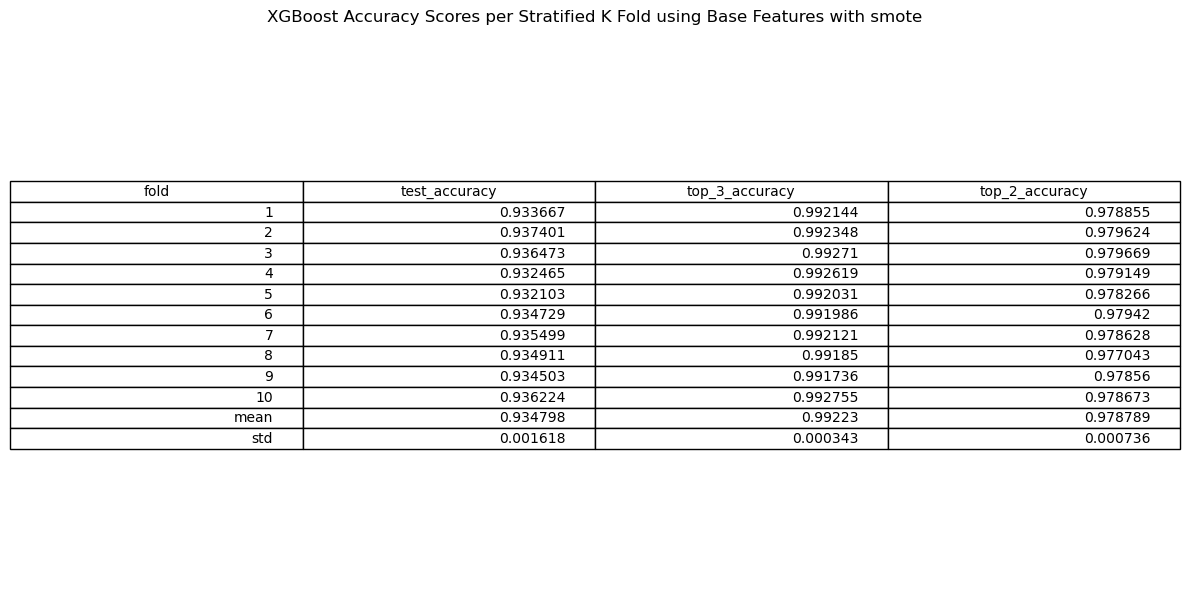

In [14]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, n_jobs=-1)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


    smote = SMOTE(n_jobs=-1, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    xgb.fit(X_train_smote, y_train_smote)
    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))

scores_dfs = {}
scores_dfs = pd.DataFrame(scoring_metrics)

mean = scores_dfs.mean()
scores_dfs.loc['mean'] = mean
std = scores_dfs.std()
scores_dfs.loc['std'] = std
scores_dfs['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_dfs[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"XGBoost Accuracy Scores per Stratified K Fold using Base Features with smote")
plt.show()
plt.close(fig)


/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You 

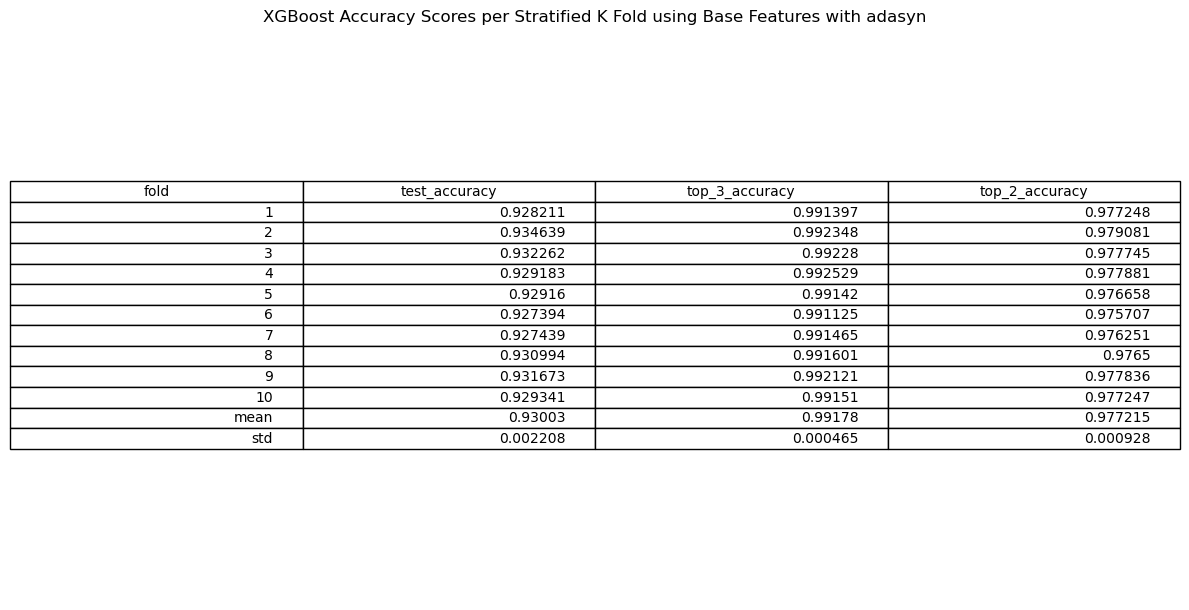

In [15]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, n_jobs=-1)
scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    adasyn = ADASYN(n_jobs=-1, random_state=42)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
    xgb.fit(X_train_adasyn, y_train_adasyn)
    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))


scores_dfs = {}
scores_dfs = pd.DataFrame(scoring_metrics)

mean = scores_dfs.mean()
scores_dfs.loc['mean'] = mean
std = scores_dfs.std()
scores_dfs.loc['std'] = std
scores_dfs['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_dfs[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"XGBoost Accuracy Scores per Stratified K Fold using Base Features with adasyn")
plt.show()
plt.close(fig)

/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will 

/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


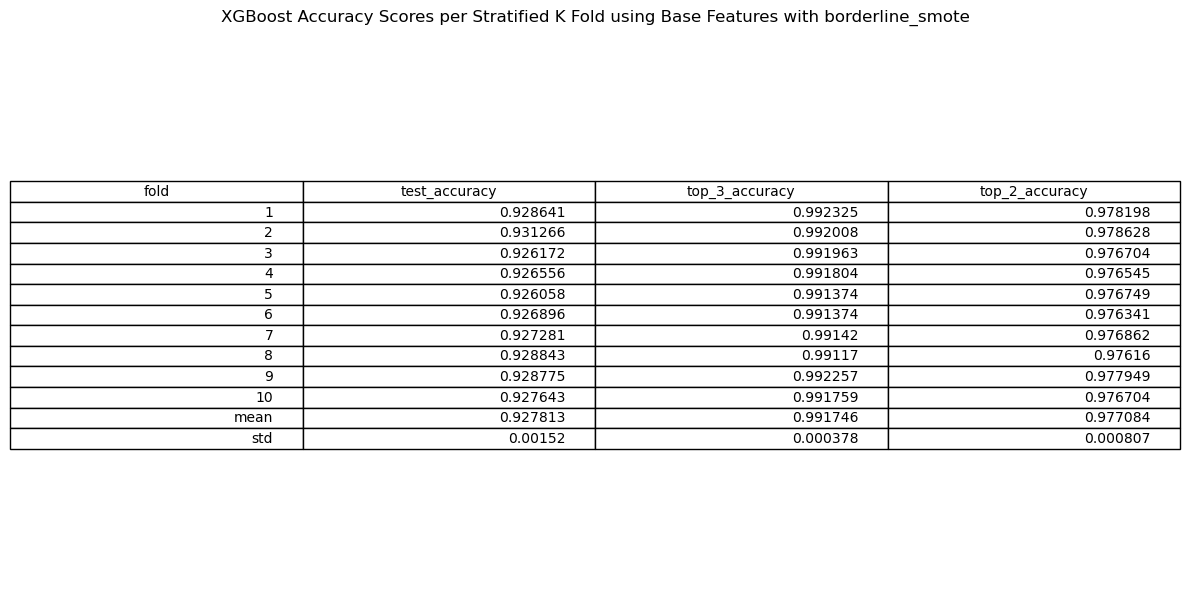

In [16]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, n_jobs=-1)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    boderline_smote = BorderlineSMOTE(n_jobs=-1, random_state=42)
    X_train_boderline_smote, y_train_boderline_smote = boderline_smote.fit_resample(X_train, y_train)
    xgb.fit(X_train_boderline_smote, y_train_boderline_smote)
    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2))


scores_dfs = {}
scores_dfs = pd.DataFrame(scoring_metrics)

mean = scores_dfs.mean()
scores_dfs.loc['mean'] = mean
std = scores_dfs.std()
scores_dfs.loc['std'] = std
scores_dfs['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_dfs[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"XGBoost Accuracy Scores per Stratified K Fold using Base Features with borderline_smote")
plt.show()
plt.close(fig)

## Undersampling

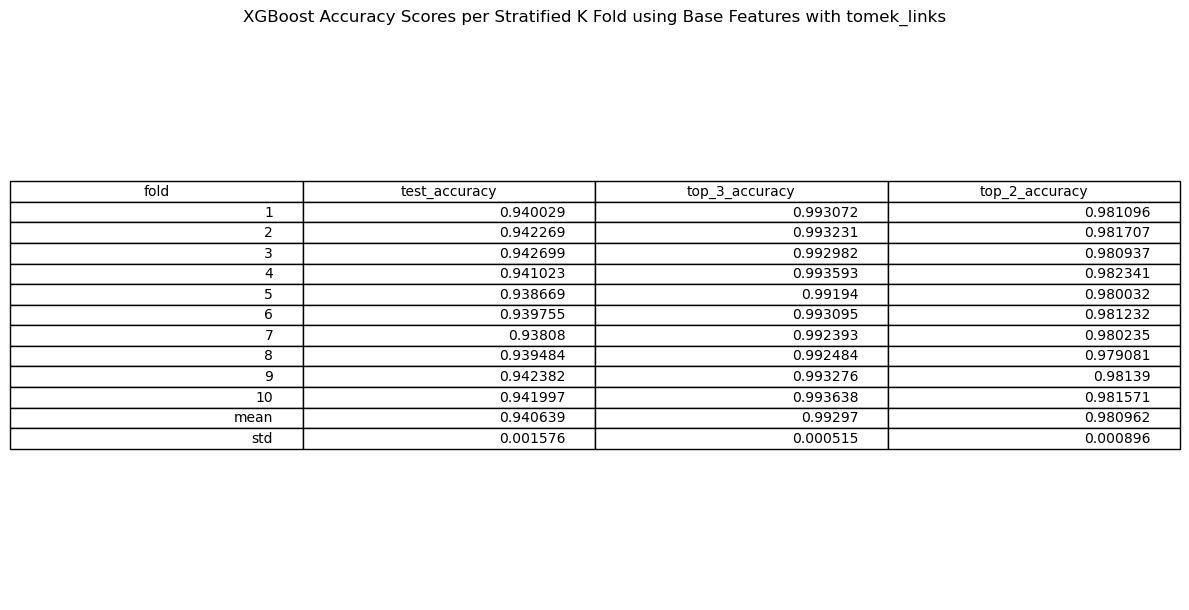

In [17]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, n_jobs=-1)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  

    tomek_links = TomekLinks(n_jobs=-1)
    X_train_tomek_links, y_train_tomek_links = tomek_links.fit_resample(X_train, y_train)
    xgb.fit(X_train_tomek_links, y_train_tomek_links)
    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2)) 

scores_dfs = {}
scores_dfs = pd.DataFrame(scoring_metrics)


mean = scores_dfs.mean()
scores_dfs.loc['mean'] = mean
std = scores_dfs.std()
scores_dfs.loc['std'] = std
scores_dfs['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_dfs[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"XGBoost Accuracy Scores per Stratified K Fold using Base Features with tomek_links")
plt.show()
plt.close(fig)

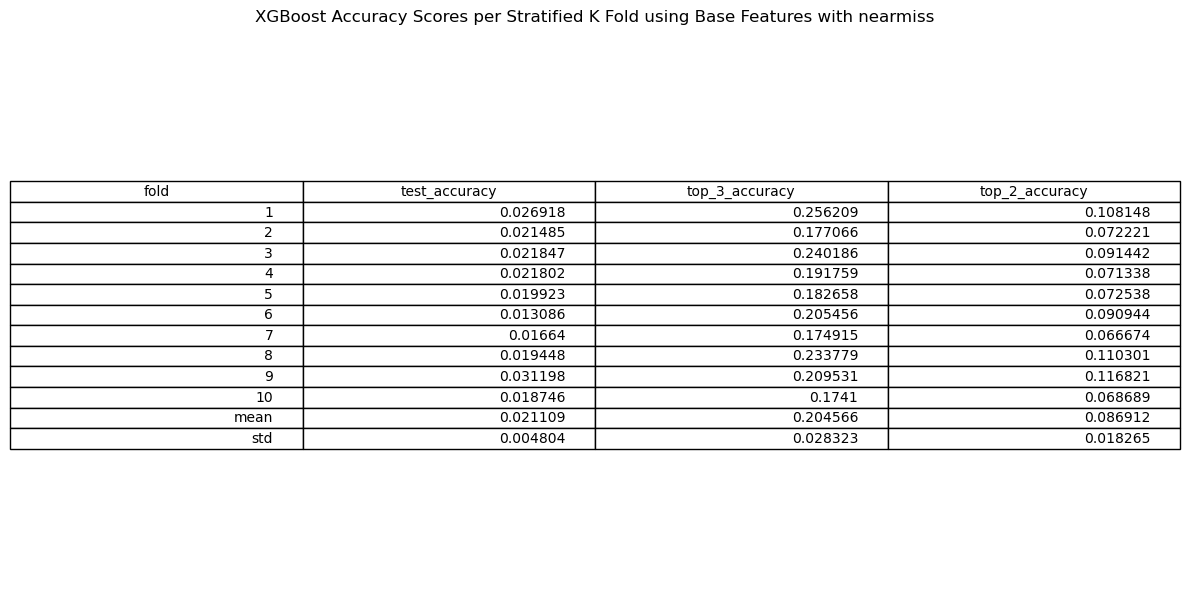

In [18]:
FEATURE_GROUP = "all_features"
INPUT_FILE = f"{FEATURE_GROUP}.csv"
df = pd.read_csv(INPUT_FILE)
df = df[~(df['label'].isin(labels_with_few_samples))].reset_index(drop=True)

df['label'], _ = column_adjustor(df['label'])
df['tld'], _ = column_adjustor(df['tld'])
df['registrar'], _ = column_adjustor(df['registrar'])
df['ip_locations'], _ = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X = X.fillna(-1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xgb = XGBClassifier(random_state=42, n_jobs=-1)

scoring_metrics = {'test_accuracy': [], 'top_3_accuracy': [], 'top_2_accuracy': []}

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  

    nearmiss = NearMiss(n_jobs=-1)
    X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)
    xgb.fit(X_train_nearmiss, y_train_nearmiss)
    y_pred = xgb.predict(X_test)
    scoring_metrics['test_accuracy'].append(accuracy_score(y_test, y_pred))
    y_pred_proba = xgb.predict_proba(X_test)
    scoring_metrics['top_3_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=3))
    scoring_metrics['top_2_accuracy'].append(top_k_accuracy_score(y_test, y_pred_proba, k=2)) 

scores_dfs = {}
scores_dfs = pd.DataFrame(scoring_metrics)

mean = scores_dfs.mean()
scores_dfs.loc['mean'] = mean
std = scores_dfs.std()
scores_dfs.loc['std'] = std
scores_dfs['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

scores = scores_dfs[['fold', 'test_accuracy', 'top_3_accuracy', 'top_2_accuracy']].round(6)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = scores.values, colLabels = scores.columns, loc="center")
plt.tight_layout()
plt.title(f"XGBoost Accuracy Scores per Stratified K Fold using Base Features with nearmiss")
plt.show()
plt.close(fig)